# Offensive Comments
https://www.kaggle.com/surekharamireddy/malignant-comment-classification

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import string
import nltk
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import pickle as pk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Data pre-processing

In [5]:
# Pre_process features
def data_pre_processor(df, vect):
    # lower case
    print('lowercase...')
    df['cleaned_text'] = df.comment_text.str.lower()
    
    # regex for emails, url, numbers, money and phone numbers
    print('clean regex...')
    df.cleaned_text = df.cleaned_text.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')
    df.cleaned_text = df.cleaned_text.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','url')
    df.cleaned_text = df.cleaned_text.str.replace(r'\d+(\.\d+)?', 'nb')
    df.cleaned_text = df.cleaned_text.str.replace(r'£|\$', 'moneyunit')
    df.cleaned_text = df.cleaned_text.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
    
    # remove punctuation
    print('remove punctuation...')
    for punct in string.punctuation+'\n':
        df.cleaned_text = df.cleaned_text.apply((lambda x: ' '.join(i for i in x.split(punct))))
    
    # stemm text
    print('lematizer...')
    stemmer = SnowballStemmer("english")
    df.cleaned_text = df.cleaned_text.apply(lambda x: ' '.join(stemmer.stem(i) for i in x.split()))

    # stopwords
    print('remove stopwords...')
    stop_words = set(stopwords.words('english') \
                     + ['im','dont','doin','ure','nb','wikipedia','u','ur','page','like','articl','peopl'])
    df.cleaned_text = df.cleaned_text.apply(lambda x: ' '.join(i for i in x.split() if i not in stop_words))
    
    # Convert into vectors with TF-IDF
    print('convert into vector...')
    parsed_text = np.array(df.cleaned_text)
    
    # If train data, the vectorizer is initiated
    if vect == None:
        vectorizer = TfidfVectorizer(max_features = 10000)
        X_vector = vectorizer.fit_transform(parsed_text)
        print('job done !')
        return df, X_vector, vectorizer
        
    # If test data, use the vectorizer defined in training step
    else:
        X_vector = vect.transform(parsed_text)
        print('job done !')
        return df, X_vector

In [6]:
%%time
cleaned_data, X, vectorizer = data_pre_processor(data, vect=None)

lowercase...
clean regex...
remove punctuation...
lematizer...
remove stopwords...
convert into vector...
job done !
Wall time: 4min 30s


In [7]:
# 0: not offensive, 1: offensive
target_col = ['malignant','highly_malignant','rude','threat','abuse','loathe']
cleaned_data['target'] = cleaned_data[target_col].sum(axis=1)/cleaned_data[target_col].sum(axis=1).astype(int)
cleaned_data.target = cleaned_data.target.fillna(0)
y = np.array(cleaned_data.target)

cleaned_data.target.value_counts()

0.0    143346
1.0     16225
Name: target, dtype: int64

In [8]:
# Loop over all the words in all the texts and increment the counts in the appropriate counter objects
def count_most_common(df,cat,number):
    count_word = Counter()
    df_cat = df[df['target'] == cat]
    for comment in df_cat['cleaned_text']:
        for word in comment.split(" "):
            count_word[word] += 1
    return count_word.most_common(number)

In [9]:
# Most common words in offensive text
count_most_common(cleaned_data,1,10)

[('fuck', 13568),
 ('suck', 4824),
 ('go', 3978),
 ('shit', 3723),
 ('nigger', 3436),
 ('ass', 3044),
 ('get', 2837),
 ('hate', 2797),
 ('faggot', 2709),
 ('edit', 2522)]

In [10]:
# Most common words in neutral text
count_most_common(cleaned_data,0,10)

[('edit', 39025),
 ('talk', 37990),
 ('use', 34094),
 ('one', 28941),
 ('pleas', 28913),
 ('would', 28155),
 ('delet', 25818),
 ('ani', 24936),
 ('thank', 23340),
 ('sourc', 23309)]

## Training classifier

In [12]:
print('X shape: {}\ny shape: {}'.format(X.shape, y.shape))

X shape: (159571, 10000)
y shape: (159571,)


In [13]:
# create train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [32]:
# cross-validator : ShuffleSplit 
sss = StratifiedShuffleSplit(n_splits = 20, test_size = 0.2, random_state = 42)

### Import classifier ###
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

# exhaustive search over specified parameter
grid = GridSearchCV(clf, param_grid = {}, verbose = 1, cv = sss)

In [33]:
%%time
# training classifier
print (" > training classifier:")
grid.fit(X_train, y_train.ravel())

# best classifier using the cross-validator and the Stratified Shuffle Split 
clf = grid.best_estimator_

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)

# Evaluation metrics
print(classification_report(y_test, clf.predict(X_test)))

 > training classifier:
Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



 > Best grid search:
{}
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     28670
         1.0       0.93      0.52      0.66      3245

    accuracy                           0.95     31915
   macro avg       0.94      0.76      0.82     31915
weighted avg       0.95      0.95      0.94     31915

Wall time: 3.43 s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished


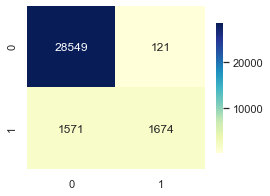

In [34]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(
    confusion_matrix(y_test, clf.predict(X_test)), 
    cmap='YlGnBu', 
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    fmt='d'
)

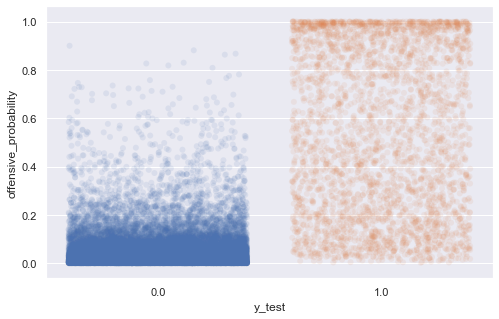

In [113]:
predicted_test_df = pd.DataFrame({
    'y_test':y_test,
    'offensive_probability':np.array([row[1] for row in clf.predict_proba(X_test)])
})

fig, ax = plt.subplots(figsize=(8, 5))
sns.stripplot(
    data=predicted_test_df, 
    x='y_test', 
    y='offensive_probability', 
    jitter=0.4,
    alpha=0.1, 
    size=6)

In [35]:
# dump vectorizer in a pickle file
with open("vectorizer_improved.pkl", 'wb') as file:
    pk.dump(vectorizer, file)

# dump classifier in a pickle file
with open("offensive_clf_improved.pkl", 'wb') as file:
    pk.dump(clf, file)

## Test on new data

In [36]:
# Load vectorizer
with open("vectorizer_improved.pkl", 'rb') as file:
    vectorizer_train = pk.load(file)
    
# Load classifier
with open("offensive_clf_improved.pkl", 'rb') as file:
    clf_trained = pk.load(file)

In [37]:
%%time
test_df = pd.read_csv('test.csv')
cleaned_new_data , X_new_data = data_pre_processor(test_df, vectorizer_train)

lowercase...
clean regex...
remove punctuation...
lematizer...
remove stopwords...
convert into vector...
job done !
Wall time: 2min 52s


In [52]:
cleaned_new_data['offensive_probability'] = np.array([row[1] for row in clf_trained.predict_proba(X_new_data)])
for row in cleaned_new_data.sample(5).iloc():
    print(row['comment_text'])
    print('\n>>> OFFENSIVE PROBABILITY: {}%'.format(round(row['offensive_probability']*100,2)))
    print(50*'_')

"::::""Reactions"" is for that. Effects is for the immediate area of operations: southern Israel and Gaza Strip. BTW, did you just quid pro quo this? The ArbCom said some choice things on quid pro quo in the whole Allegations of apartheid debacle.   

 "

>>> OFFENSIVE PROBABILITY: 2.92%
__________________________________________________
F  you. Don't u ever correct my pages you stupdip girl rot were you belong u ugly whale by the on facebook his username is Simphwe Zulu

>>> OFFENSIVE PROBABILITY: 60.64%
__________________________________________________
Your recent edits to the talk page of the seventh generation of gaming, in regards to iPods/iPhones/iPads being hand-held dedicated game consoles could be seen as zealous, or even anti-NPoV.

>>> OFFENSIVE PROBABILITY: 4.47%
__________________________________________________
" 

  
 Soviet Union fell in 1991. However, the page states ""The law was not repealed until after the fall of the Soviet Union in 1993."" I'm going to remove the

lowercase...
clean regex...
remove punctuation...
lematizer...
remove stopwords...
convert into vector...
job done !

SUBMITTED COMMENT: Im stuck on that stupid program no matter what I do :( can somebody help ?


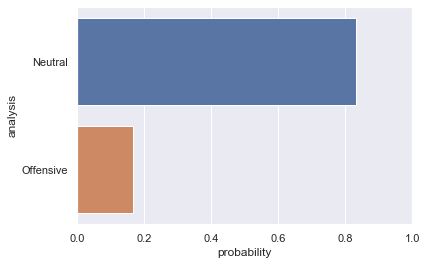

In [64]:
sentence = 'Im stuck on that stupid program no matter what I do :( can somebody help ?'

user_data = pd.DataFrame({'comment_text':[sentence]})
cleaned_user_data , X_user_data= data_pre_processor(user_data, vectorizer_train)

result_df = pd.DataFrame({
    'analysis':['Neutral','Offensive'],
    'probability': clf_trained.predict_proba(X_user_data)[0]
})

print('\nSUBMITTED COMMENT: '+sentence)
sns.barplot(data=result_df, x='probability', y='analysis', orient='h');
plt.xlim(0,1);